In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import optimize
import networkx as nx
from hashlib import blake2b
from collections import Counter, defaultdict
import itertools
import time
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
import cvxpy as cp

In [2]:
with open("../data-challenge-kernel-methods-2022-2023/training_data.pkl", "rb") as f:
    train_data = pickle.load(f)

with open("../data-challenge-kernel-methods-2022-2023/training_labels.pkl", "rb") as f:
    train_labels = pickle.load(f)

with open("../data-challenge-kernel-methods-2022-2023/test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

In [3]:
train_data = np.array(train_data, dtype=object)
train_labels = np.array(train_labels, dtype=int)
test_data = np.array(test_data, dtype=object)

In [4]:
train_labels_svm = train_labels.copy()
train_labels_svm[train_labels_svm == 0] = -1
np.unique(train_labels_svm)

array([-1,  1])

In [5]:
class WLKernel:
    def __init__(self, edge_attr="labels", node_attr="labels", iterations=3):
        self.edge_attr = edge_attr
        self.node_attr = node_attr
        self.n_iter = iterations
    
    def _hash_label(self, label, digest_size):
        return blake2b(label.encode("ascii"), digest_size=digest_size).hexdigest()

    def _neighborhood_aggregate(self, G, node, node_labels):
        """
        Compute new labels for given node by aggregating
        the labels of each node's neighbors.
        """
        label_list = []
        for nbr in G.neighbors(node):
            prefix = "" if self.edge_attr is None else str(G[node][nbr][self.edge_attr])
            label_list.append(prefix + node_labels[nbr])
        return node_labels[node] + "".join(sorted(label_list))

    def weisfeiler_lehman_graph_hash(self, G, digest_size=16):
        def weisfeiler_lehman_step(G, labels):
            """
            Apply neighborhood aggregation to each node
            in the graph.
            Computes a dictionary with labels for each node.
            """
            new_labels = {}
            for node in G.nodes():
                label = self._neighborhood_aggregate(G, node, labels)
                new_labels[node] = self._hash_label(label, digest_size)
            return new_labels

        # set initial node labels
        node_labels = {u: str(dd[self.node_attr]) for u, dd in G.nodes(data=True)}

        subgraph_hash_counts = {}
        for it in range(self.n_iter):
            node_labels = weisfeiler_lehman_step(G, node_labels)
            counter = Counter(node_labels.values())
            # normalize counter
            total = np.sum(list(counter.values()))
            for k in counter:
                counter[k] /= total

            # sort the counter, extend total counts
            subgraph_hash_counts[it] = sorted(counter.items(), key=lambda x: x[0])

        # return _hash_label(str(tuple(subgraph_hash_counts)), digest_size)
        return subgraph_hash_counts
    
    
    def compute_phi(self, Z):
        phi_list = []
        for g in Z:
            phi_list.append(self.weisfeiler_lehman_graph_hash(g))
        return phi_list
    
    def compute_kernel(self, wl1, wl2):
        k = 0
        for i in range(self.n_iter):
            dict1 = dict(wl1[i])
            dict2 = dict(wl2[i])
            # take scalar product only on common keys
            common_keys = set(dict1.keys()).intersection(set(dict2.keys()))
            k += np.sum([dict1[c]*dict2[c] for c in common_keys])
        return k

    def compute_kernel_matrix(self, X, Y):
        # Precompute phi to deal only with dot products
        phi_X = self.compute_phi(X)
        if np.array_equal(X, Y):
            print("Not computing phi again as X=Y")
            phi_Y = phi_X.copy()
        else:
            phi_Y = self.compute_phi(Y)
        ker = np.zeros((len(X), len(Y)))
        count_iter = 0
        if len(X) == len(Y):
            for i in range(len(X)):
                for j in range(i, len(Y)):
                    ker[i, j] = self.compute_kernel(phi_X[i], phi_Y[j])
                    ker[j, i] = ker[i,j]
                count_iter += 1
                if count_iter % 100 == 0:
                    print(f"Iteration {count_iter}")
        else:
            for (i,j) in itertools.product(range(len(X)), range(len(Y))):
                ker[i,j] = self.compute_kernel(phi_X[i], phi_Y[j])
        print("Kernel computed")
        return ker

In [6]:
class KernelPerceptron:
    
    def __init__(self, kernel_mat, epsilon = 1e-3, n_iter=100):
        self.kernel = kernel_mat        
        self.norm_f = None
        self.alpha = None
        self.n_iter = n_iter
        self.training_data = None
        self.weights = None
        self.accuracy = 0
        self.opt_alpha = None
        self.acc_list = []
    
    def compute_weights(self, y):
        N = len(y)
        w_neg = np.sum(y == -1.)
        w_pos = np.sum(y == 1.)
        self.weights = np.array([N/(2*w_neg) if val==-1. else N/(2*w_pos) for val in y])
        
    def fit(self, X, y, K=None, valX=None, valY=None, K_val=None):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        if K is None:
            K = self.kernel(X, X)
        self.alpha = np.zeros(N)
        
        # Correct for imbalanceness
        self.compute_weights(y)
        for it in range(self.n_iter):
            y_pred = np.sign((self.weights*self.alpha).T@K)
            for i in range(N):
                if y_pred[i] == y[i]:
                    continue
                self.alpha[i] += y[i]
            if valX is not None:
                y_pred_val = np.sign((self.weights*self.alpha).T@K_val)
                acc = f1_score(y_pred_val, valY, average="macro")
                self.acc_list.append(acc)
                if acc > self.accuracy:
                    self.accuracy = acc
                    self.opt_alpha = self.alpha.copy()
                    
        self.training_data = X
        
    
    def predict(self, X, K=None):
        """ Predict y values in {-1, 1} """
        if K is None:
            K = self.kernel(self.training_data, X)
        return np.sign((self.weights*self.opt_alpha).T@K)

In [7]:
class KernelLR:
    """ Logistic Regression classifier.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If
        false then we use batch optimization by least squares.
    """
    def __init__(self, learning_rate=.1, regul=0):
        self.param = None
        self.learning_rate = learning_rate
        self.regul = regul
        self.accuracy = 0
        self.param_opt = None
        self.acc_list = []
        
    def sigmoid(self, x):
        res = 1/(1 + np.exp(-x))
        return res
    
    def sigmoid_grad(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))

    def fit(self, X, y, valX, valY, n_iter=4000):
        
        # Init params
        n = X.shape[0]
        lim = 1 / np.sqrt(n)
        self.param = np.random.uniform(-lim, lim, (n,))
    
        # Correct for imbalanceness
        w_neg, w_pos = np.bincount(y)
        w_pred = np.array([n/(2*w_neg) if val==0. else n/(2*w_pos) for val in y])
        
        # Run for n_iter epochs
        for i in range(n_iter):
            # Make a new prediction
            y_pred = self.sigmoid(self.param@X)
           
            # Gradient descent step
            self.param = self.param - self.learning_rate * (- X@((y - y_pred)*w_pred) + 2*self.regul*self.param)
           
            # Calculate predictions on validation data
            val_pred = np.round(self.sigmoid(self.param@valX)).astype(int)
            acc = f1_score(valY, val_pred, average="macro")
            self.acc_list.append(acc)
            if acc > self.accuracy:
                self.accuracy = acc
                self.param_opt = self.param.copy()
            
            
    def predict(self, X):
        y_pred = np.round(self.sigmoid(self.param_opt@X)).astype(int)
        return y_pred

In [8]:
class KernelLRCVX:
    """ Logistic Regression classifier.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If
        false then we use batch optimization by least squares.
    """
    def __init__(self):
        self.param_opt = None
        
    def sigmoid(self, x):
        res = 1/(1 + np.exp(-x))
        return res
    
    def sigmoid_grad(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))

    def fit(self, X, y, n_iter=4000):
        
        # Init params
        n = X.shape[0]
        lim = 1 / np.sqrt(n)
    
        # Correct for imbalanceness
        w_neg, w_pos = np.bincount(y)
        w_pred = np.array([n/(2*w_neg) if val==0. else n/(2*w_pos) for val in y])
        
        
        # Solve optim pb
        alpha = cp.Variable(n)
        lambd = cp.Parameter(nonneg=True)
        log_likelihood = cp.sum(
            cp.multiply(y, (alpha.T @ X)) - cp.logistic(alpha.T @ X)
        )
        pb = cp.Problem(cp.Maximize(log_likelihood/n - lambd*cp.norm(alpha, 1)))
        
        # fix for now regularization param
        lambd.value = .5
        pb.solve(solver='ECOS', verbose=True, abstol=1e-4)
        self.param_opt = alpha.value            
            
    def predict(self, X):
        y_pred = ((self.param_opt.T @ X) > 0).astype(int)
        return y_pred

In [9]:
K = np.load("../matrices/WL_kernel_train_5it.npy")
K_test = np.load("../matrices/WL_kernel_test_5it.npy")
K.shape, K_test.shape

((6000, 6000), (2000, 6000))

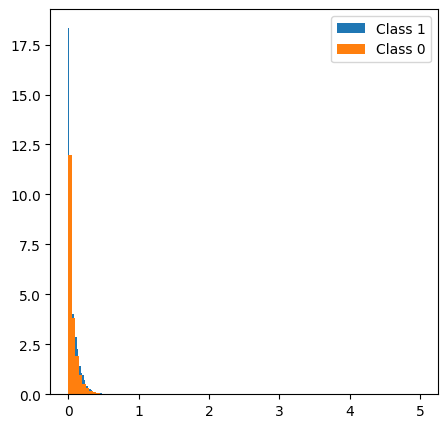

In [10]:
plt.figure(figsize=(5,5))
plt.hist(K[train_labels.astype(bool), :].ravel(), bins=100, density=True, label="Class 1")
plt.hist(K[~train_labels.astype(bool), :].ravel(), bins=100, density=True, label="Class 0")
plt.legend(loc='upper right')
plt.show()


In [11]:
neg, pos = np.bincount(train_labels.astype(int))
neg_freq = neg/len(train_labels)
pos_freq = pos/len(train_labels)

idx_neg = np.argwhere(train_labels == 0).ravel()
idx_pos = np.argwhere(train_labels == 1).ravel()
fold_idx = {}
for fold in range(1, 5):
    idx_neg_fold = np.random.choice(idx_neg, neg*20//100, replace=False)
    idx_neg = np.setdiff1d(idx_neg, idx_neg_fold)
    idx_pos_fold = np.random.choice(idx_pos, pos*20//100, replace=False)
    idx_pos = np.setdiff1d(idx_pos, idx_pos_fold)
    fold_idx[fold] = np.sort(np.concatenate([idx_neg_fold, idx_pos_fold]))

fold_idx[5] = np.sort(np.concatenate([idx_pos, idx_neg]))

In [ ]:
## Kernel CVXOPT
res_folds = {}
for fold in fold_idx:
    print(f"\nProcessing fold {fold}")
    idx_val = fold_idx[fold]
    idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
    K_train = K[idx_train, :][:, idx_train]
    K_val = K[idx_train, :][:, idx_val]
    log = KernelLRCVX()
    log.fit(K_train, train_labels[idx_train])
    
    # validation
    val_pred = log.predict(K_val, train_labels[idx_val])
    acc = f1_score(train_labels[idx_val], val_pred, average="macro")
    res_folds[fold] = {"acc": acc, "params": log.param_opt}
    print(f"Results : acc={acc}")



Processing fold 1
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 05 11:40:25 AM: Your problem has 4800 variables, 0 constraints, and 1 parameters.
(CVXPY) Apr 05 11:40:25 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 05 11:40:25 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 05 11:40:25 AM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 05 11:40:25 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 05 11:40:25 AM: Applying reduction FlipObjective
(CVXPY) Apr 05 11:40:25 AM:

In [ ]:
res_folds = {}
for fold in fold_idx:
    print(f"\nProcessing fold {fold}")
    idx_val = fold_idx[fold]
    idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
    K_train = K[idx_train, :][:, idx_train]
    K_train /= np.sum(K_train, axis=1)[:, None]
    K_val = K[idx_train, :][:, idx_val]
    K_val /= np.sum(K_val, axis=1)[:, None]
    log = KernelLR(learning_rate=.000005, regul=1)
    log.fit(K_train, train_labels[idx_train], K_val, train_labels[idx_val], n_iter=100)
    res_folds[fold] = {"acc": log.accuracy, "params": log.param_opt, "acc_list":log.acc_list, "last_params":log.param}
    print(f"Results : acc={log.accuracy}")
    plt.figure(figsize=(4,4))
    plt.plot(log.acc_list)
    plt.show()

In [141]:
# get model with best performance on validation data
acc_folds = [res_folds[fold]['acc'] for fold in res_folds]
best_fold = list(fold_idx.keys())[np.argmax(acc_folds)]
best_param = res_folds[best_fold]['params']
best_acc = res_folds[best_fold]['acc']
best_acc_list = res_folds[best_fold]["acc_list"]
last_param = res_folds[best_fold]['last_params']
print(f"Best fold is {best_fold} with macro f1 score {best_acc}")

Best fold is 5 with macro f1 score 0.6410016816907039


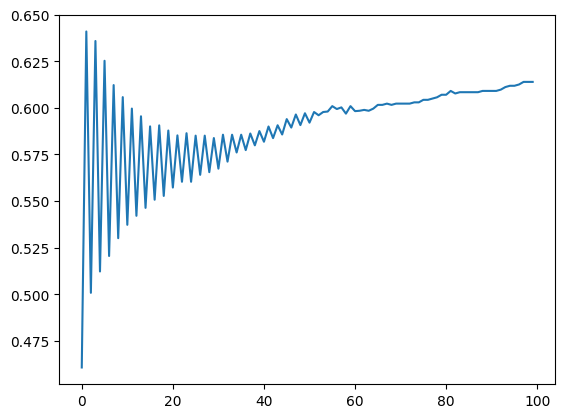

In [142]:
plt.plot(best_acc_list)

In [143]:
# Apply on validation again
idx_best_val = fold_idx[best_fold]
idx_best_train = np.setdiff1d(np.arange(len(train_labels)), idx_best_val)
K_best_val = K[idx_best_train,:][:, idx_best_val]
log = KernelLR(learning_rate=.5)
log.param_opt = best_param
best_val = log.predict(K_best_val)
print(classification_report(train_labels[idx_best_val], best_val))
log.param_opt = last_param
last_val = log.predict(K_best_val)
print(classification_report(train_labels[idx_best_val], last_val))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1089
           1       0.28      0.70      0.40       111

    accuracy                           0.80      1200
   macro avg       0.62      0.76      0.64      1200
weighted avg       0.90      0.80      0.84      1200

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1089
           1       0.25      0.86      0.39       111

    accuracy                           0.75      1200
   macro avg       0.61      0.80      0.61      1200
weighted avg       0.91      0.75      0.80      1200



In [134]:
test = log.predict(K_test.T[idx_best_train,:])

In [136]:
np.unique(test, return_counts=True)

(array([0, 1]), array([1814,  186]))

In [30]:
test_preds = test.copy()
test_preds[test_preds == -1] = 0
Yte = {'Predicted' : test_preds}
dataframe = pd.DataFrame(Yte) 
dataframe.index += 1 
dataframe.to_csv('test_pred_klr_5folds.csv',index_label='Id')

In [30]:
kernel_mat = WLKernel(iterations=5).compute_kernel_matrix

Processing fold 1
Results : acc=0.5049185963313386


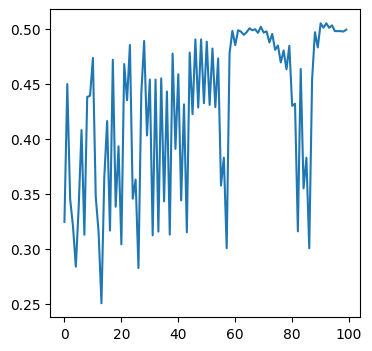

Processing fold 2
Results : acc=0.5401834461672854


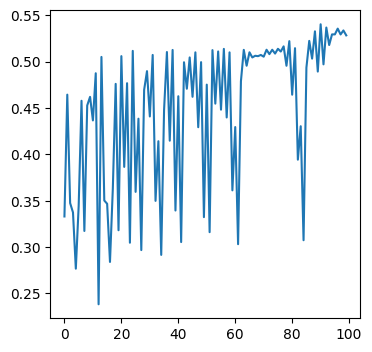

Processing fold 3
Results : acc=0.5172816765541843


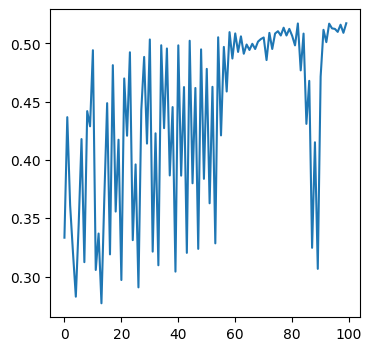

Processing fold 4
Results : acc=0.5224288121554851


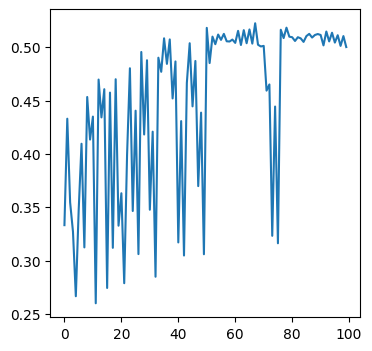

Processing fold 5
Results : acc=0.5239656230816452


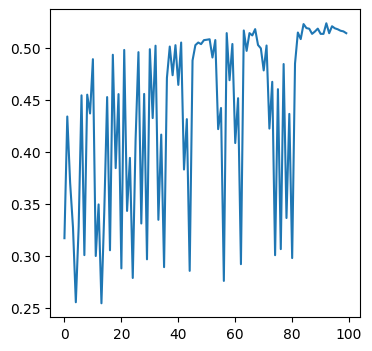

In [52]:
per_folds = {}
for fold in fold_idx:
    print(f"Processing fold {fold}")
    idx_val = fold_idx[fold]
    idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
    K_train = K[idx_train, :][:, idx_train]
    K_val = K[idx_train, :][:, idx_val]
    per = KernelPerceptron(kernel_mat=kernel_mat, epsilon=.1, n_iter=100)
    per.fit(X=train_data[idx_train], 
            y=train_labels_svm[idx_train], 
            K=K_train, 
            valX=train_data[idx_val], 
            valY=train_labels_svm[idx_val], 
            K_val=K_val)
    per_folds[fold] = {"acc": per.accuracy, "params": per.opt_alpha, "acc_list":per.acc_list}
    print(f"Results : acc={per.accuracy}")
    plt.figure(figsize=(4,4))
    plt.plot(per.acc_list)
    plt.show()

In [53]:
# get model with best performance on validation data
acc_list = [per_folds[fold]['acc'] for fold in per_folds]
best_fold = list(fold_idx.keys())[np.argmax(acc_list)]
best_param = per_folds[best_fold]['params']
best_acc = per_folds[best_fold]['acc']
best_acc_list = per_folds[best_fold]['acc_list']
print(f"Best fold is {best_fold} with macro f1 score {best_acc}")

Best fold is 2 with macro f1 score 0.5401834461672854


In [47]:
# Apply on validation again
idx_best_val = fold_idx[best_fold]
idx_best_train = np.setdiff1d(np.arange(len(train_labels)), idx_best_val)
K_best_val = K[idx_best_train,:][:, idx_best_val]
per = KernelPerceptron(kernel_mat=kernel_mat, epsilon=.1, n_iter=100)
per.opt_alpha = best_param
best_val = per.predict(train_data[idx_best_val], K_best_val)
print(classification_report(train_labels_svm[idx_best_val], best_val))

AttributeError: 'KernelPerceptron' object has no attribute 'weights'

In [22]:
test = per.predict(test_data, K_test.T[idx_best_train,:])

In [23]:
np.unique(test, return_counts=True)

(array([-1.,  0.,  1.]), array([1626,    6,  368]))

In [24]:
prev = pd.read_csv("test_pred.csv")
prev["Predicted"].sum()

347.0